<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [18]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle 
from scipy.stats import skew
from scipy.stats.stats import pearsonr

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [19]:
# Load the data
house = pd.read_csv('./housing.csv')

In [20]:
house.shape

(1460, 81)

### 1- Import Data and do preliminary check

In [21]:
def EDA_S1(path):
    df=pd.read_csv(path)
    
    
    print("Data frame columns informations:")
    print (df.info())
    print ("------------------------------------------------------------------------------")
    
    print("Data frame dimensions (Raw, Columns):")
    print (df.shape)
    print ("------------------------------------------------------------------------------")
    
    print ("Data frame states :")
    print (df.describe())
    print ("------------------------------------------------------------------------------")
   
    print ("Data frame null values count :")
    print (df.isnull().sum())
    print ("------------------------------------------------------------------------------")
    
    print ("Data frame na values count :")
    print (df.isna().sum())
    print ("------------------------------------------------------------------------------")
    

    return df.head()


In [22]:
EDA_S1('./housing.csv')

Data frame columns informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null o

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### *- List Columns names with high number of null values.*

In [23]:
house_null=round(100*(house.isna().sum()/len(house.index)), 2)
pd.DataFrame(house_null)
house_null.sort_values(ascending=False,inplace=True)
house_null=house_null>50
dropped_col=house_null[house_null==True].index
dropped_col

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')

 ### *- Drop the columns with more than 50% null values.*

In [24]:
house_new_1=house.drop(columns=dropped_col)
house_new_1.shape
# house_new_1 this is our new dataframe that we will use moving forward

(1460, 77)

###  Removing any houses that are not residential from the dataset.

*- Only MSZoning feature seemed to have indication if the unit is resdential or not.*

*- I will drop all "C - Commercial" Units.*

In [25]:
house_new_1.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [26]:
house_new_1=house_new_1[house_new_1.MSZoning != 'C (all)']

In [27]:
house_new_1.shape
# 10 Raws now dropped

(1450, 77)

In [28]:
house_new_1.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
                ... 
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageCars         0
GarageArea         0
GarageQual        79
GarageCond   

In [29]:
house_new_1.YrSold.describe()

count    1450.000000
mean     2007.812414
std         1.326321
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64

### Filling NA for numerical variables

 *- NA's replaced with the mean.*

In [30]:
house_new_1 = house_new_1.fillna(house_new_1.mean())

### Finding Correlations

 *- In this step I calcualted the correlation between my numerical featuers Keeping those who are above 50% correlation, and give it a rank from Highest to lowest.*

These are my fixed features:  ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']


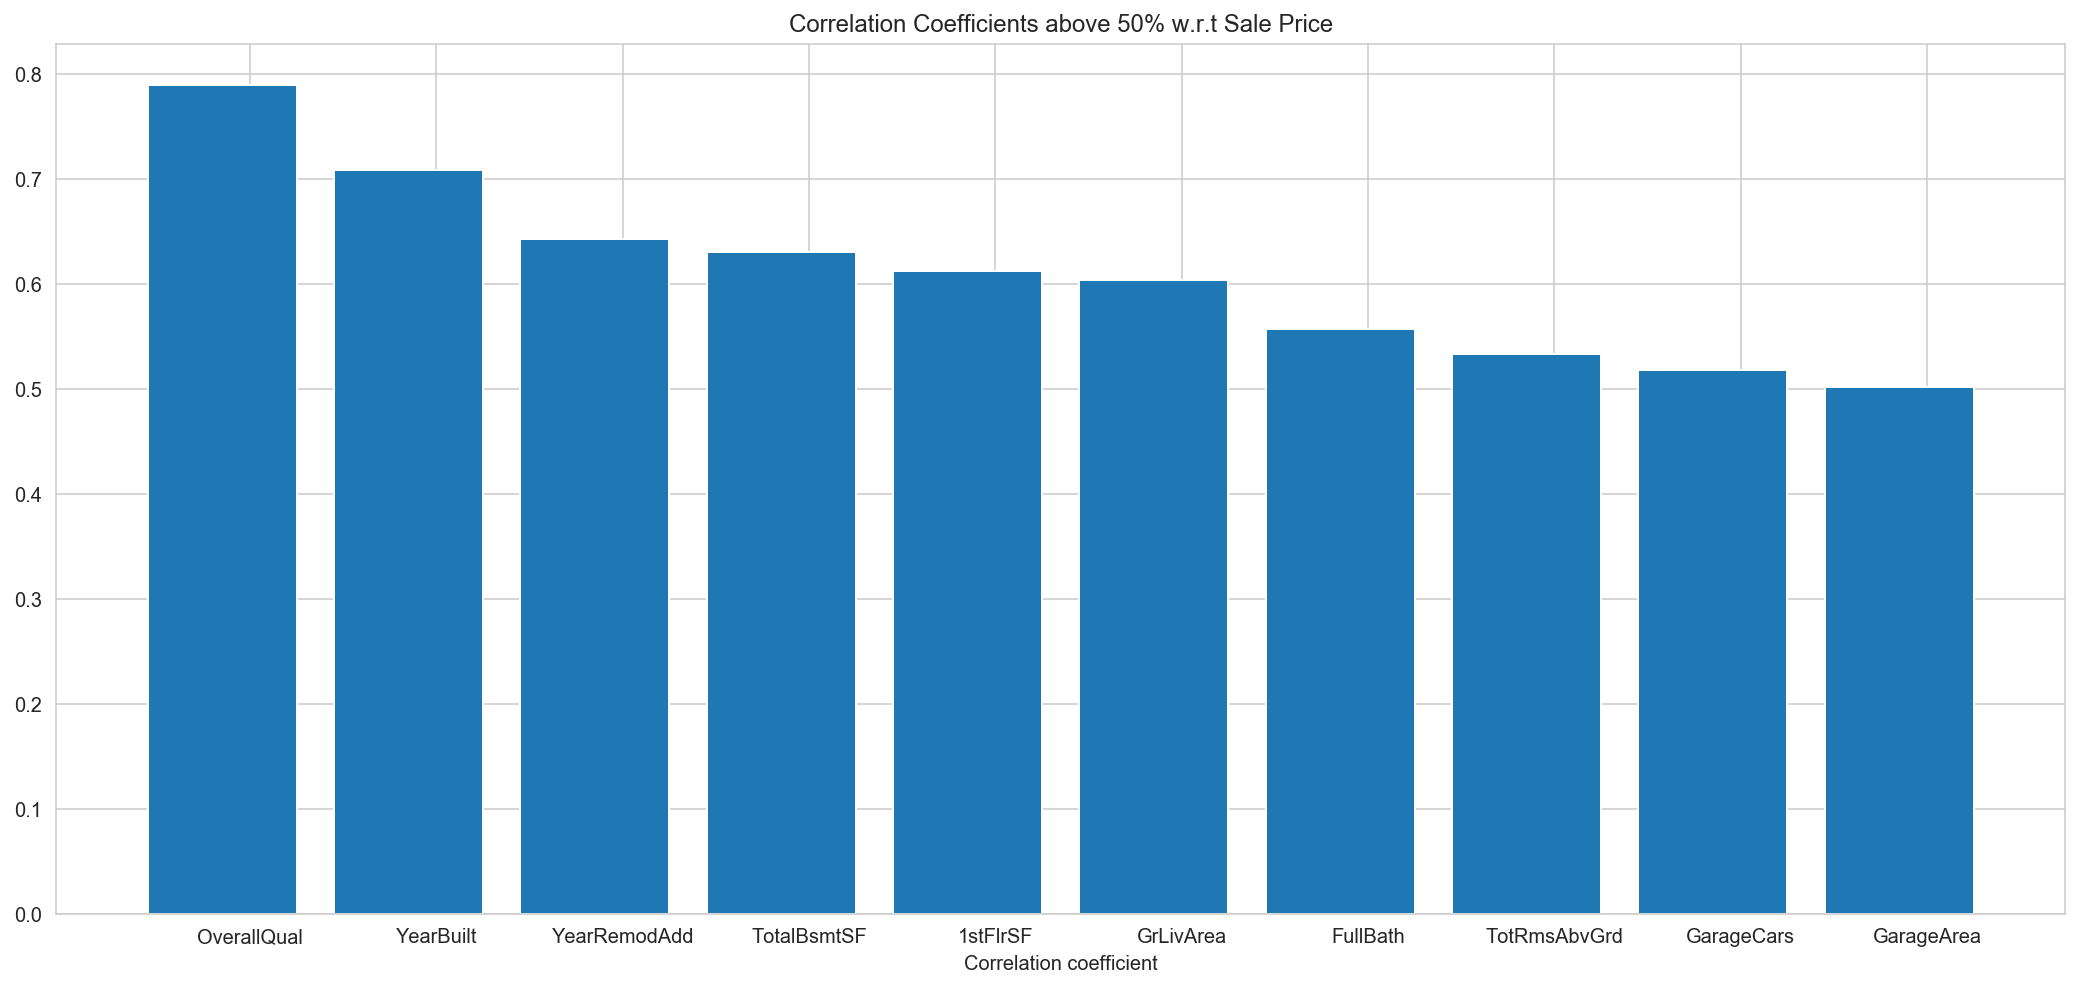

In [31]:
#plotting correlations
num_feat=house_new_1.columns[house_new_1.dtypes != object]
num_feat=num_feat[1:-1] 

labels = []
values = []
for col in num_feat:
    value=(np.corrcoef(house_new_1[col].values, house_new_1.SalePrice.values)[0,1])
    if value>.5:
        values.append(value)
        labels.append(col)
values.sort(reverse=True)    
ind = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots(figsize=(18,8))
rects = ax.bar(ind, np.array(values))
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients above 50% w.r.t Sale Price")
print ("These are my fixed features: ",labels)

### Checking for Multicollinearity

 *- In this step I checked the correlation between different featuers trying to find highly correlated pairs, and choosing one only to keep in order to avoid Multicollinearty in my regression model.*

In [32]:
from itertools import permutations 
perm = permutations(labels, 2) 

b=[]
c=[]
for i in list(perm):
    a=list(i)
    b.append(a[0])
    c.append(a[1])

In [33]:
correlated_labels = []
correlation_values = []

for i in range(0,(len(b)-1)):
    value=(np.corrcoef(house_new_1[b[i]].values, house_new_1[c[i]].values)[0,1])
    if value>.5:
        correlation_values.append(value)
        correlated_labels.append([b[i],c[i]])
           

In [34]:
(np.corrcoef(house_new_1['1stFlrSF'].values, house_new_1['GrLivArea'].values)[0,1])

0.5640979813897804

/Users/sherf/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


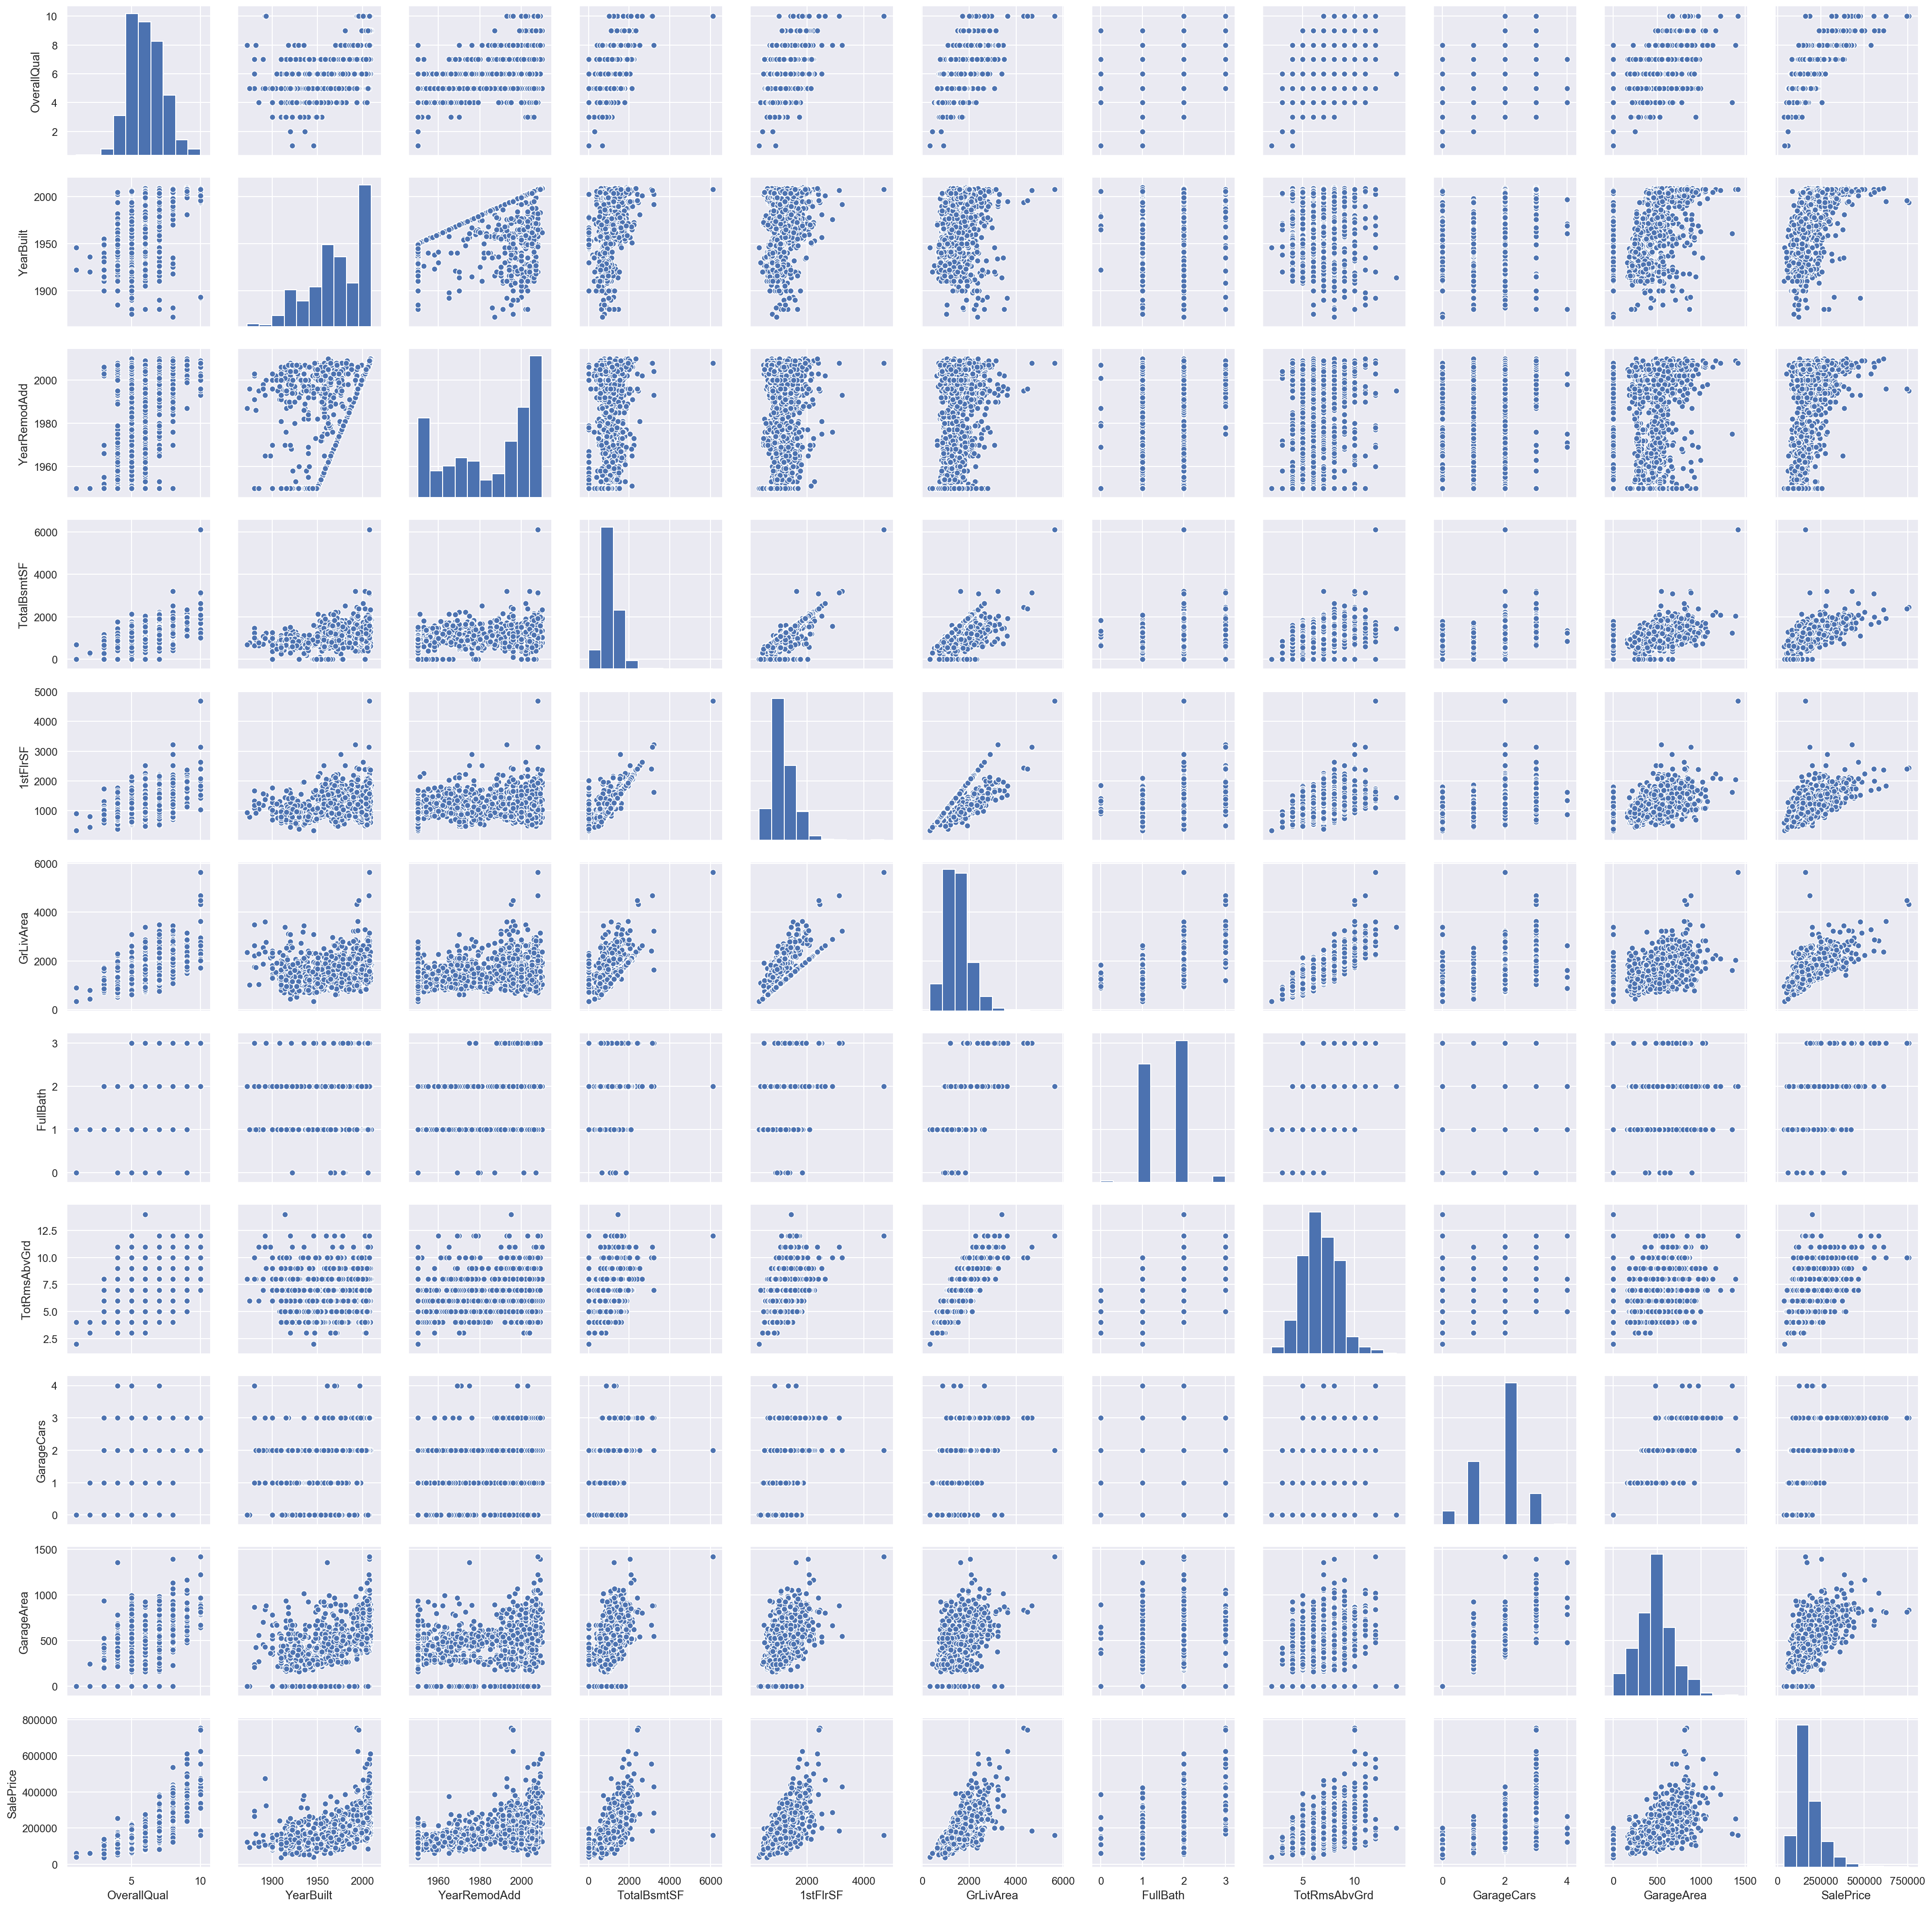

In [35]:
Price_feat_rel=pd.concat([house_new_1[labels],house_new_1['SalePrice']],axis=1)
sns.set()
sns.pairplot(Price_feat_rel, size = 2.5)
plt.show();

### Identifying catagorical variables with NA's


In [36]:
cat_feat_null=house_new_1.columns[house_new_1.isna().sum()>0]
cat_feat_null

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')

In [37]:
cat_feat=house_new_1[cat_feat_null].fillna(value='NA')

In [38]:
cat_feat.shape

(1450, 12)

In [39]:
cat_feat['Electrical'].value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NA          1
Name: Electrical, dtype: int64

### *- Electrical was the only one with NA that needed to be removed because it is not one of the catagories, while others have.*

In [40]:
cat_feat=pd.DataFrame(cat_feat)
cat_feat.head()
# cat_feat=cat_feat.drop(cat_feat['Electrical'].isna()==True,axis=1)
cat_feat['Electrical'].isna().value_counts()

False    1450
Name: Electrical, dtype: int64

In [41]:
print(num_feat)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [42]:
# house_new_1.get_dtype_counts()
cat_feat.get_dtype_counts()

object    12
dtype: int64

In [43]:
# this is our catagorical features DF 
cat_feat.head(3)

,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond
0,BrkFace,Gd,TA,No,GLQ,Unf,SBrkr,NA,Attchd,RFn,TA,TA
1,None,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA
2,BrkFace,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA


### *-Now let us have our cleaned dataframe with numerical and catagorical featuers.* 

In [44]:
#creating our new DF with all cleaned data
all_data=house_new_1.join(cat_feat,how='left', lsuffix='_New')
all_data.drop(labels=cat_feat.columns,axis=1,inplace=True)

### One more step, check the price for Normality and homoscadasticity.

/Users/sherf/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


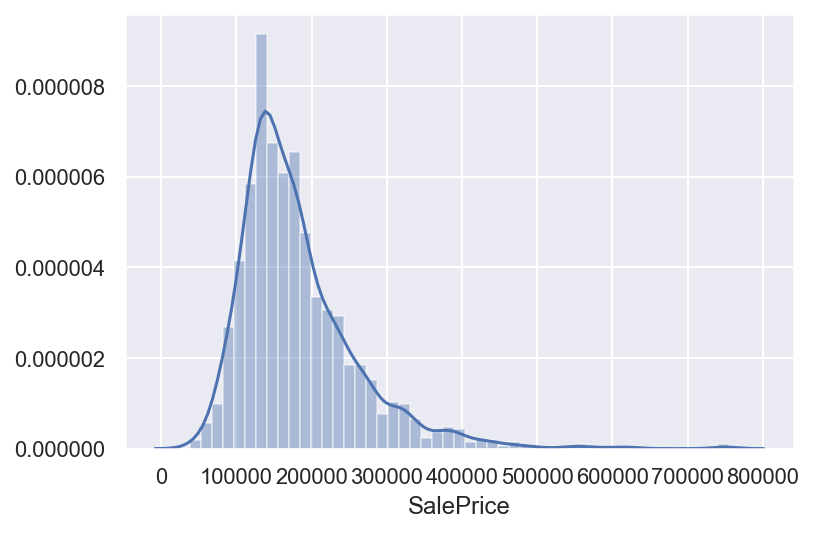

In [45]:
#Moving on to Examine Sales Price  
sns.distplot(all_data.SalePrice)

*The price is skewd we will take use the log transformation to fix that.*

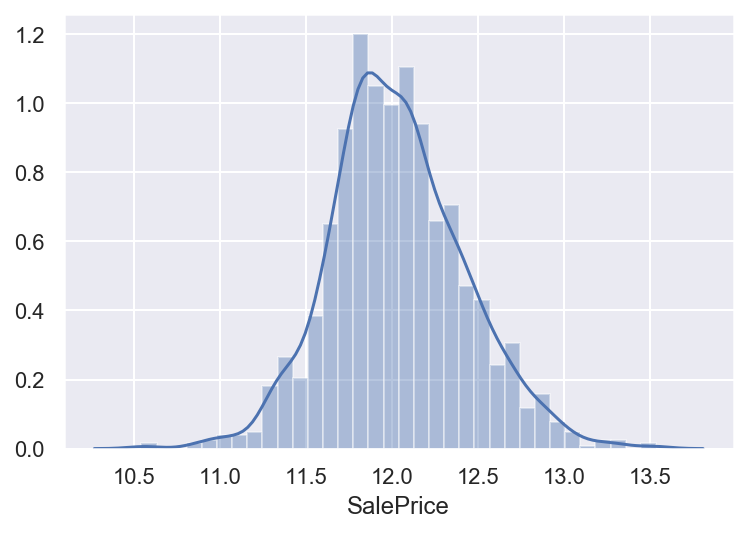

In [46]:
sns.distplot(np.log(all_data["SalePrice"]))

*Now This looks much better!*

In [47]:
# Converting Sales price to log scale to improve our model  
all_data["Price_log"] = np.log(all_data["SalePrice"])

### - Getting dummy variables for all catagorical featuers.

In [48]:
all_data = pd.get_dummies(all_data,drop_first=True)

### - Dividing Data into train and test based on year sold. 

In [49]:
all_data.sort_values('YrSold',inplace=True,ascending=True)
all_data_test=all_data[all_data.YrSold == 2010]
all_data_train=all_data[all_data.YrSold != 2010]

In [50]:
all_data_test.shape

(172, 238)

In [51]:
all_data_train.shape

(1278, 238)

In [102]:
y_train=all_data_train[['SalePrice']]
X_train=all_data_train.drop(labels='SalePrice',axis=1)
X_train_fixed=X_train[['GrLivArea','YearBuilt','1stFlrSF','YearRemodAdd']]
X_train_fixed.head()

,GrLivArea,YearBuilt,1stFlrSF,YearRemodAdd
1183,1130,1920,1130,1950
270,1939,2006,1095,2006
831,1200,2005,520,2005
266,1511,1997,802,1997
1231,1190,1962,1190,1962


In [103]:
y_test=all_data_test[['SalePrice']]
X_test=all_data_test.drop(labels='SalePrice',axis=1)
X_test_fixed=X_test[['GrLivArea','YearBuilt','1stFlrSF','YearRemodAdd']]

In [104]:
(y_train.shape,X_train.shape)

((1278, 1), (1278, 237))

In [105]:
(y_test.shape,X_test.shape)

((172, 1), (172, 237))

### And, Finally our frist Linear Regression Model using *Statsmodel*.

In [106]:
import statsmodels.api as sm

In [107]:
#Linear Regression using Statsmodel
X = X_train_fixed
y = y_train

model = sm.OLS(y,X).fit()

y_pred = model.predict(X)

In [108]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     4564.
Date:                Tue, 25 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:19:25   Log-Likelihood:                -15658.
No. Observations:                1278   AIC:                         3.132e+04
Df Residuals:                    1274   BIC:                         3.135e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
GrLivArea       84.2379      3.290     25.602      0.000      77.783      90.693
YearBuilt      576.2415     58.986      9.769      0.000     460.521     691.962
1stFlrSF        49.8358      4.534     10.991      0.000      40.941      58.731
YearRemodAdd  -574.3601     58.419     -9.832      0.000    -688.969    -459.752
==============================================================================
Omnibus:                      357.228   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13158.417
Skew:                          -0.575   Prob(JB):                         0.00
Kurtosis:                      18.677   Cond. No.                         199.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/sherf/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


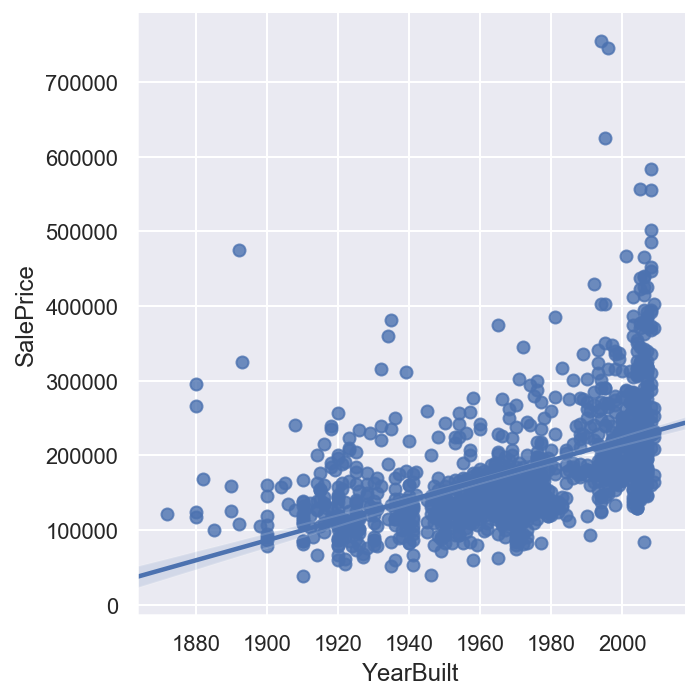

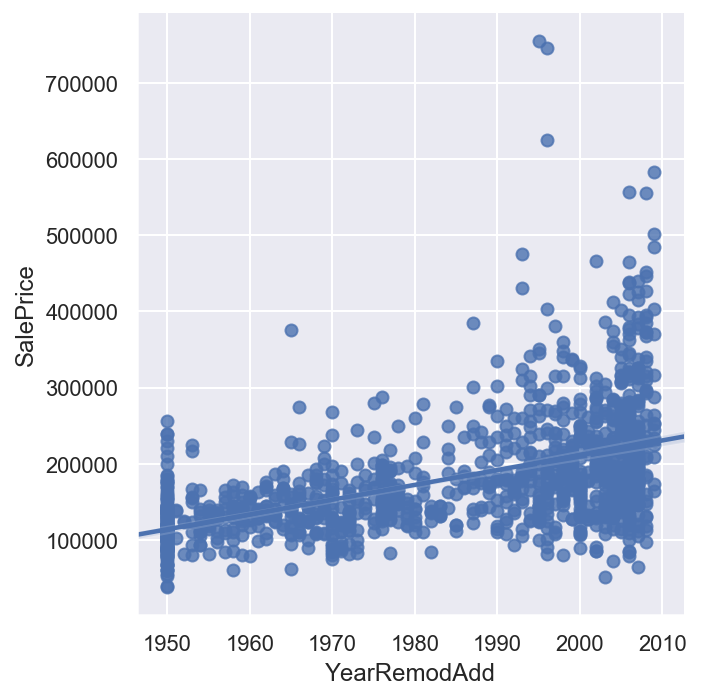

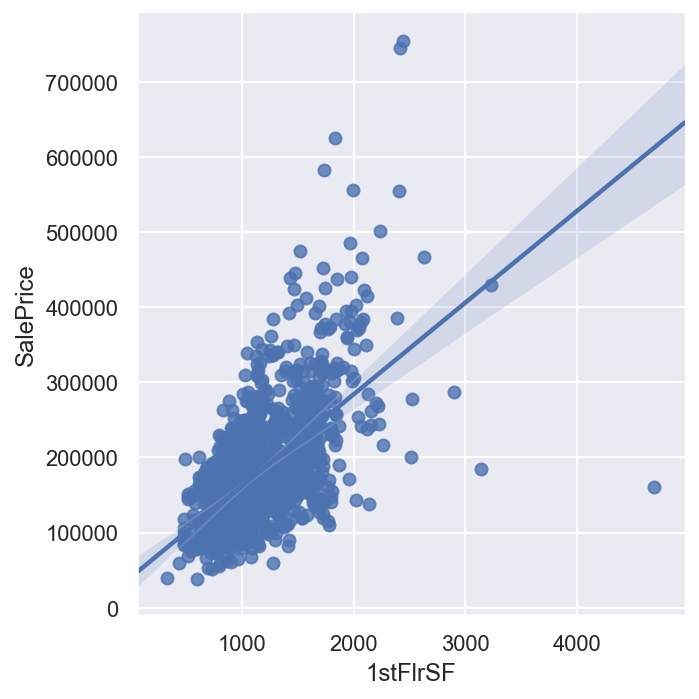

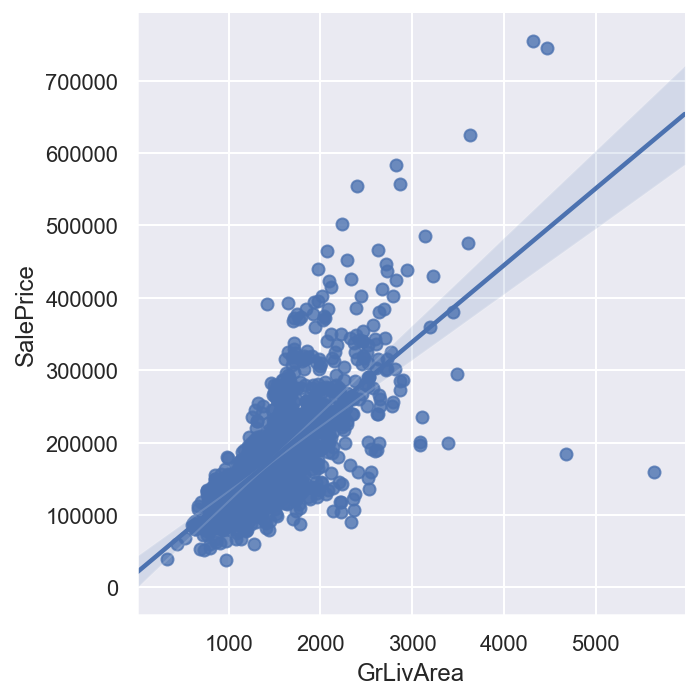

In [112]:
sns.lmplot(x='YearBuilt', y='SalePrice', data=all_data_train)
sns.lmplot(x='YearRemodAdd', y='SalePrice', data=all_data_train)
sns.lmplot(x='1stFlrSF', y='SalePrice', data=all_data_train)
sns.lmplot(x='GrLivArea', y='SalePrice', data=all_data_train)

### Moving on into sklearn Linear Regression Model

In [120]:
from sklearn.preprocessing import StandardScaler,RobustScaler,robust_scale
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error
import math

In [122]:
#Linear Regression using Scikit_Learn Including fixed featuers only
RS=RobustScaler()
X_train_fixed=RS.fit_transform(X_train_fixed)
X_test_fixed=RS.fit_transform(X_test_fixed)

model_lr=LinearRegression()
model_lr.fit(X_train_fixed, y_train)

score_train=  model_lr.score(X_train_fixed, y_train)
score_test=  model_lr.score(X_test_fixed, y_test)

y_pred = model_lr.predict(X_test_fixed)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)

print(model_lr.coef_)
print("-------------------------------------------------")
print ("Model Training Score =",round((score_train*100),2),"%" )
print ("Model Test Score =",round((score_test*100),2),"%" )
print('RMSE: {}'.format(rmse))

[[47725.23889268 33083.28800608 21482.46129713 21969.21644964]]
-------------------------------------------------
Model Training Score = 69.1 %
Model Test Score = 71.76 %
RMSE: 42369.39618973924


*In this step i was trying to compare the two models coef to see the difference, one take out from here is stats model makes it easier to check my model parameters easy. this allowed me to make imporvments manually and better understand the issues and solve it.*

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.